# Transfer Matrix Calculations

import necessary pacakges 

if this is used in a paper cite Steven J. Brynes (creator of tmm package) arxiv paper: https://arxiv.org/pdf/1603.02720.pdf

In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d

#ColorPy package allows you to convert a spectrum into a color you would see
#downloaded from Github https://github.com/fish2000/ColorPy 
#note that PyPI version is only compatible with Python 2 - Github is compatible with 2 & 3
from colorpy import colormodels, illuminants 

#TMM package does all transfer matrix calculations
#installed from PyPI
from tmm import coh_tmm, absorp_in_each_layer, color 

define plot style

In [2]:
%config InlineBackend.figure_format = 'retina' #to make inline images higher res

plt.style.use(['presplot'])
#plt.rcParams["figure.figsize"] = [8,8]

load nk data - as a dictionary with the different materials as items, arrays are lambda (microns), n, k

In [3]:
nkdata_raw = scipy.io.loadmat('nkdata.mat')

initialize stack parameters

In [4]:
# list of materials in stack
mat_list=np.array(["SiO_2","Pt","WS_2","Ag"])
# list of layer thicknesses in nm, start and end with inf
d_list = np.array([np.inf,1700,10,80,100,np.inf])
# list of wavelengths
ldas=np.arange(400,800,1).reshape(-1,1)
#polarization
pol="s"
#angle
theta=0;

interpolate nk data

In [5]:
nkdata={}
for mat in mat_list:
    raw=nkdata_raw[mat+"_raw"]
    n_raw=interp1d(raw[:,0],raw[:,1],fill_value="extrapolate")
    k_raw=interp1d(raw[:,0],raw[:,2],fill_value="extrapolate")
    n=n_raw(ldas/1000)
    k=k_raw(ldas/1000)
    nkdata[mat]=np.column_stack((ldas,n,k))

actual transfer matrix calculation

In [6]:
#initialize all matrices
R=np.zeros(np.shape(ldas))
T=np.zeros(np.shape(ldas))
A=np.zeros(np.shape(ldas))
a_layer=np.zeros((np.size(ldas),np.size(mat_list)))

#loop over all wavelengths
i=0
for lda in ldas:    
    
    #initialize n_list, index
    n_list=np.ones(np.size(d_list),dtype=complex)
    j=0
    
    #calculate n,k at this wavelength for each material, populate n_list
    for mat in mat_list:
        j+=1
        nk=nkdata[mat]
        n_list[j]=nk[i,1]+nk[i,2]*1j
        
    #TMM
    coh_tmm_data=coh_tmm(pol,n_list,d_list,theta,lda)
    
    #absorption in each layer
    a=absorp_in_each_layer(coh_tmm_data)
    
    #add to arrays 
    R[i,0]=coh_tmm_data["R"]
    T[i,0]=coh_tmm_data["T"]
    A[i,0]=1-coh_tmm_data["R"]-coh_tmm_data["T"]
    a_layer[i,:]=a[1:np.size(mat_list)+1]

    i+=1

plot absorption in all layers

(0, 1)

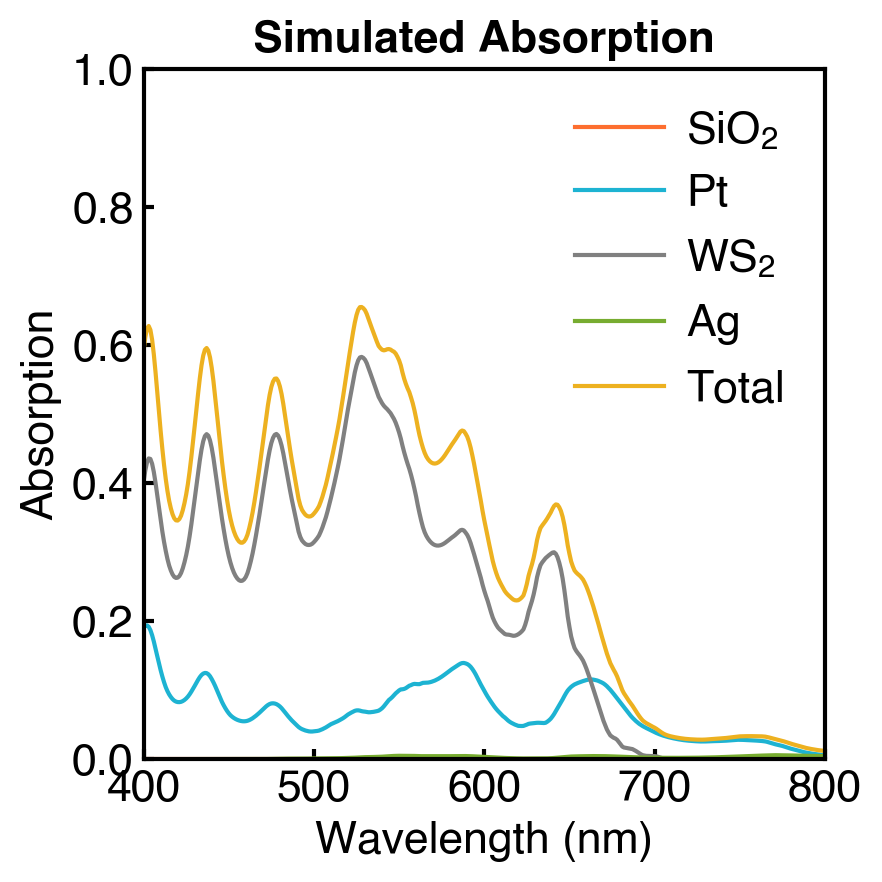

In [7]:
fig,ax=plt.subplots()

i=0
for mat in mat_list:
    ax.plot(ldas,a_layer[:,i],label="$"+mat+"$")
    i+=1
    
ax.plot(ldas,np.sum(a_layer,axis=1),label="Total")    
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Absorption")
ax.legend(loc="upper right")
ax.set_title('Simulated Absorption')
ax.set_xlim([400,800])
ax.set_ylim([0,1])

determine color of exfoliated flake

RGB = [0.21100293 0.36867033 0.50772413] , xyY = [0.2617233378327763, 0.2909756558839561, 0.345182709306412]
Saving plot temp_plot.png
Saving plot temp_plot.png


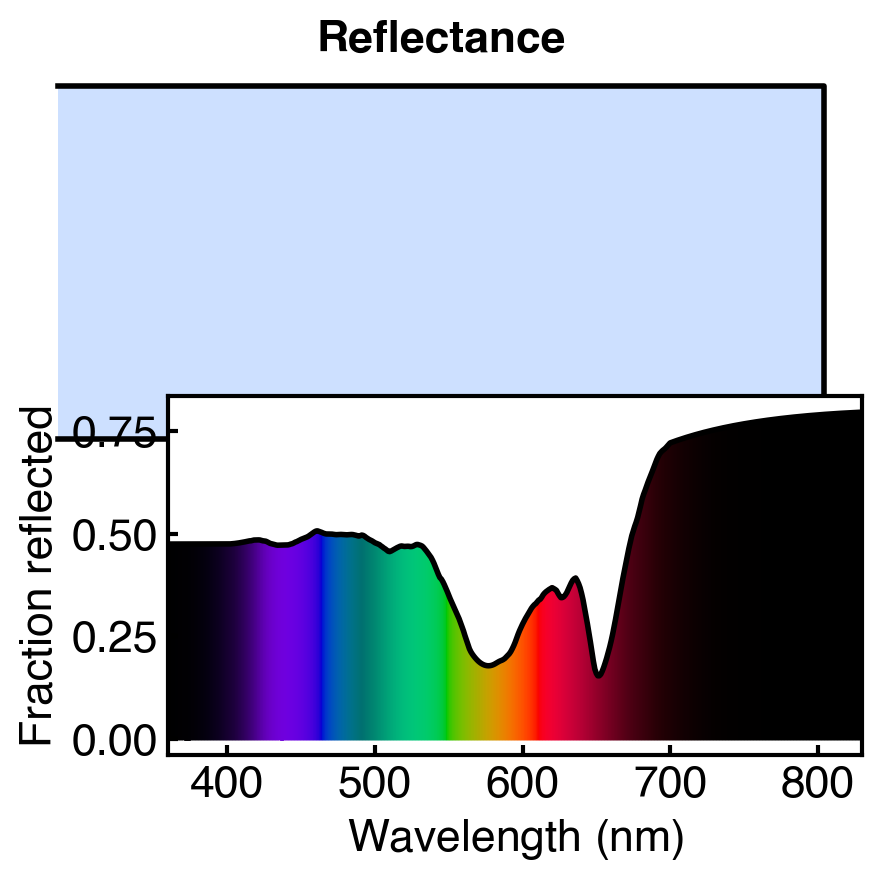

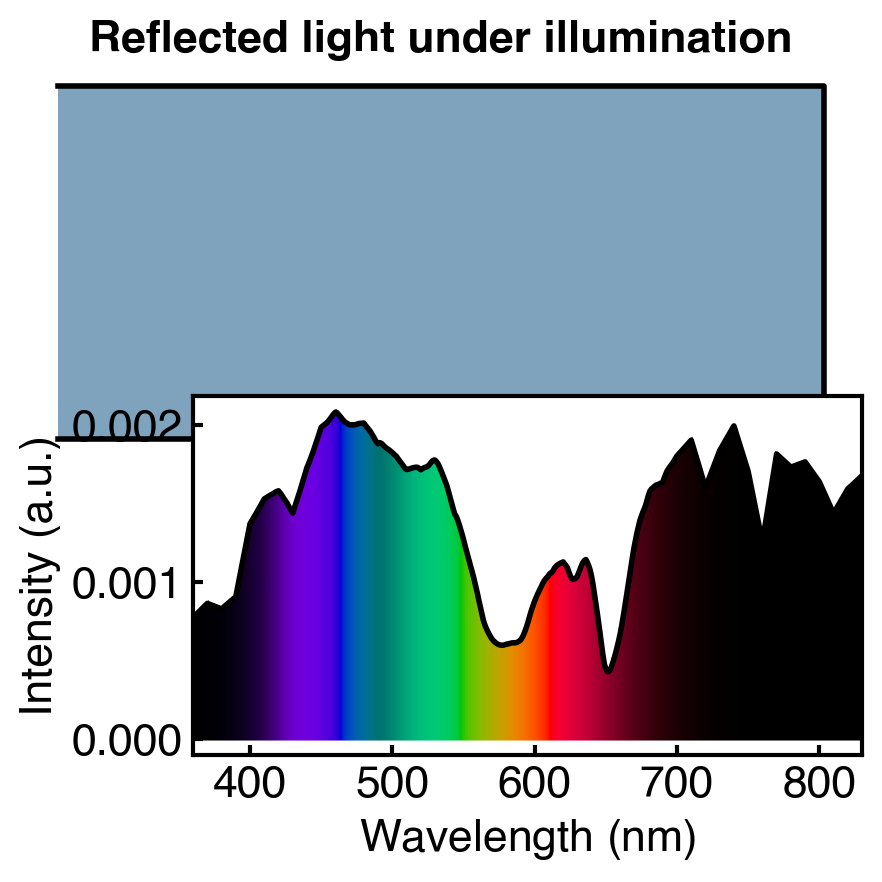

In [57]:
color_mat_list=np.flip(mat_list[0:3])
#color_d_list=np.flip(d_list[0:4])
color_d_list=np.array([np.inf,80,10,np.inf])

i=0
n_fn={}
for mat in mat_list:
    raw=nkdata_raw[mat+"_raw"]
    mat_n_fn=interp1d(raw[:,0]*1000,raw[:,1]+raw[:,2]*1j,fill_value="extrapolate")
    n_fn[mat]=mat_n_fn

air_n_fn = lambda wavelength : 1
    
n_fn_list=[air_n_fn,n_fn["WS_2"],n_fn["Pt"],n_fn["SiO_2"]]

reflectances = color.calc_reflectances(n_fn_list, color_d_list, theta)
illuminant = illuminants.get_illuminant_D65()
spectrum = color.calc_spectrum(reflectances, illuminant)
color_dict = color.calc_color(spectrum)
print('RGB =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
plt.figure()
color.plot_reflectances(reflectances)
plt.figure()
color.plot_spectrum(spectrum)